<a href="https://colab.research.google.com/github/luizfmoura/datascience/blob/master/Luiz_Fernando_De_Moura_Final_Assignment_Semantic_Segmentation_2021_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Final Assignment - Semantic Segmentation**

Objective: Implement a U-Net Network for Semantic Segmentation

Dataset: ISPRS 2D Semantic Labeling Challenge (Vaihingen)

<figure>
<center>
<img src= 'https://drive.google.com/uc?export=view&id=19wmyEXtnTV8gMOn02FPeJ8JcVSKVOycH'/>
</figure>

In the code below the network was trained only with image Train1.

In the assignment you should use both Train1 and Train2 images to train. 

Notice that you will have to adapt the so that the network will take as imput an image concatenated with its DSM.




# **1. Import libraries**

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Jan 31 18:25:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from osgeo import ogr, gdal

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Activation, Dense, Flatten, Dropout, concatenate, Conv2D, MaxPool2D, UpSampling2D, Conv2DTranspose, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# **2. Defining root folder**

In [ ]:
# root_path will be used to store trained models

from google.colab import drive
# mount your Google Drive
drive.mount('/content/drive', force_remount=True)

# adjust the path to the location where the models will be written / read
root_path = '/content/drive/My Drive/Colab Notebooks/'

Mounted at /content/drive


# **3. Loading the data**

In [ ]:
# Downloading the dataset and unpacking it.
# 6 files: Test_Image.tif, Test_DSM.tif, Test_Reference.tif, Train1_Image.tif, Train1_DSM.tif, Train1_Reference.tif, Train2_Image.tif, Train2_DSM.tif, Train2_Reference.tif

!wget https://github.com/gilson-costa/files/raw/main/Images_Semantic_Segmentatio_Assignment.part1.rar
!wget https://github.com/gilson-costa/files/raw/main/Images_Semantic_Segmentatio_Assignment.part2.rar
!wget https://github.com/gilson-costa/files/raw/main/Images_Semantic_Segmentatio_Assignment.part3.rar
!unrar e Images_Semantic_Segmentatio_Assignment.part1.rar


--2022-01-31 18:26:03--  https://github.com/gilson-costa/files/raw/main/Images_Semantic_Segmentatio_Assignment.part1.rar
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gilson-costa/files/main/Images_Semantic_Segmentatio_Assignment.part1.rar [following]
--2022-01-31 18:26:03--  https://raw.githubusercontent.com/gilson-costa/files/main/Images_Semantic_Segmentatio_Assignment.part1.rar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25165824 (24M) [application/octet-stream]
Saving to: ‘Images_Semantic_Segmentatio_Assignment.part1.rar’

Images_Semantic_Seg 100%[===================>]  24.00M  --.

In [ ]:
# Listing the contents of the virtual machine.
!ls -l

total 226224
drwx------ 5 root root     4096 Jan 31 18:25 drive
-rw-r--r-- 1 root root 25165824 Jan 31 18:26 Images_Semantic_Segmentatio_Assignment.part1.rar
-rw-r--r-- 1 root root 25165824 Jan 31 18:26 Images_Semantic_Segmentatio_Assignment.part2.rar
-rw-r--r-- 1 root root  9414015 Jan 31 18:26 Images_Semantic_Segmentatio_Assignment.part3.rar
drwxr-xr-x 1 root root     4096 Jan  7 14:33 sample_data
-rw-r--r-- 1 root root 28852100 Aug 19  2014 Test_DSM.tif
-rw-r--r-- 1 root root 21789756 Nov  1  2013 Test_Image.tif
-rw-r--r-- 1 root root 22326104 Apr 28  2014 Test_Reference.tif
-rw-r--r-- 1 root root 19707152 Aug 19  2014 Train1_DSM.tif
-rw-r--r-- 1 root root 14870332 Nov  1  2013 Train1_Image.tif
-rw-r--r-- 1 root root 15259952 Apr 28  2014 Train1_Reference.tif
-rw-r--r-- 1 root root 19398356 Aug 19  2014 Train2_DSM.tif
-rw-r--r-- 1 root root 14643100 Nov  1  2013 Train2_Image.tif
-rw-r--r-- 1 root root 15036852 Apr 28  2014 Train2_Reference.tif


In [ ]:
# Functions

def load_tiff_image(image):
  print (image)
  gdal_header = gdal.Open(image)
  img_gdal = gdal_header.ReadAsArray()
  img = np.transpose(img_gdal, (1,2,0))
  return img

def load_dsm_image(image):
  print (image)
  gdal_header = gdal.Open(image)  
  img_gdal = gdal_header.ReadAsArray()
  #img = np.transpose(img_gdal, (1,2,0))
  return img_gdal

def normalization(image):
  image_reshaped = image.reshape((image.shape[0]*image.shape[1]),image.shape[2])
  scaler = MinMaxScaler(feature_range=(0,1))
  scaler = scaler.fit(image_reshaped)
  image_normalized_ = scaler.fit_transform(image_reshaped)
  image_normalized = image_normalized_.reshape(image.shape[0],image.shape[1],image.shape[2])
  return image_normalized

In [ ]:
# Loading and normalizing images

reference_train = load_tiff_image('Train1_Reference.tif')
reference_train_2 = load_tiff_image('Train2_Reference.tif')
print(reference_train.shape)
print(reference_train_2.shape)
image_train = load_tiff_image('Train1_Image.tif').astype(float)
image_dsm = load_dsm_image('Train1_DSM.tif')
image_train_2 = load_tiff_image('Train2_Image.tif').astype(float)
image_dsm_2 = load_dsm_image('Train2_DSM.tif')

concatenated_train = np.array(concatenate([image_train,np.expand_dims(image_dsm,axis = 2)],axis = 2))
concatenated_train_2 = np.array(concatenate([image_train_2,np.expand_dims(image_dsm_2, axis = 2)],axis = 2))


# Normalizes training image (pixel values from 0 to 1)
image_train = normalization(image_train)
image_train_2 = normalization(image_train_2)

concatenated_train = normalization(concatenated_train)
concatenated_train_2 = normalization(concatenated_train_2)

print(image_train.shape)
print(image_dsm.shape)
print(image_train_2.shape)
print(image_dsm_2.shape)
print(concatenated_train.shape)
print(concatenated_train_2.shape)

reference_test = load_tiff_image('Test_Reference.tif')
print(reference_test.shape)
image_test = load_tiff_image('Test_Image.tif')
# Normalizes testing image (pixel values from 0 to 1)
image_test = normalization(image_test)
print(image_test.shape)


Train1_Reference.tif
Train2_Reference.tif
(2565, 1919, 3)
(2546, 1903, 3)
Train1_Image.tif
Train1_DSM.tif
Train2_Image.tif
Train2_DSM.tif
(2565, 1919, 3)
(2565, 1919)
(2546, 1903, 3)
(2546, 1903)
(2565, 1919, 4)
(2546, 1903, 4)
Test_Reference.tif
(2558, 2818, 3)
Test_Image.tif
(2558, 2818, 3)


# **4. Creating labeled images from references**

In [ ]:
# Defining number of classes and class indices in relation to reference images (RGB)

num_classes = 6
color2label = {
    (255, 255, 255) : 0,  # Impervious surfaces
    (0,   255, 255) : 1,  # Low vegetation
    (0,     0, 255) : 2,  # Building
    (0,   255,   0) : 3,  # Tree
    (255, 255,   0) : 4   # Car
}

def create_label_image(rgb_image):
  W = np.power(256, [[0],[1],[2]])
  img_index = rgb_image.dot(W).squeeze(-1) 
  values = np.unique(img_index)
  label_image = np.zeros(img_index.shape)
  for i, c in enumerate(values):
    try:
      label_image[img_index==c] = color2label[tuple(rgb_image[img_index==c][0])] 
    except:
      pass
  return label_image

In [ ]:
# Tranforming regerence RGB images into label images

labels_train = create_label_image(reference_train)
labels_train_2 = create_label_image(reference_train_2)
print(labels_train.shape)
print(labels_train_2.shape)
labels_test = create_label_image(reference_test)
print(labels_test.shape)

(2565, 1919)
(2546, 1903)
(2558, 2818)



Plotting images...


(-0.5, 2817.5, 2557.5, -0.5)

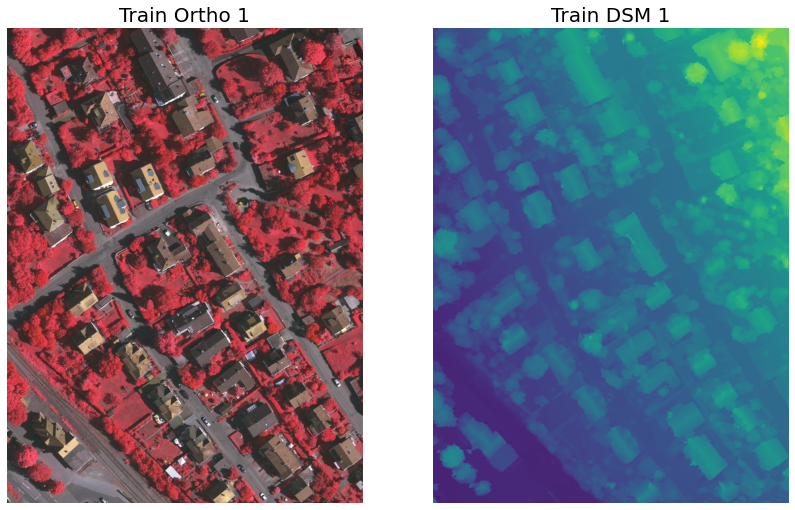

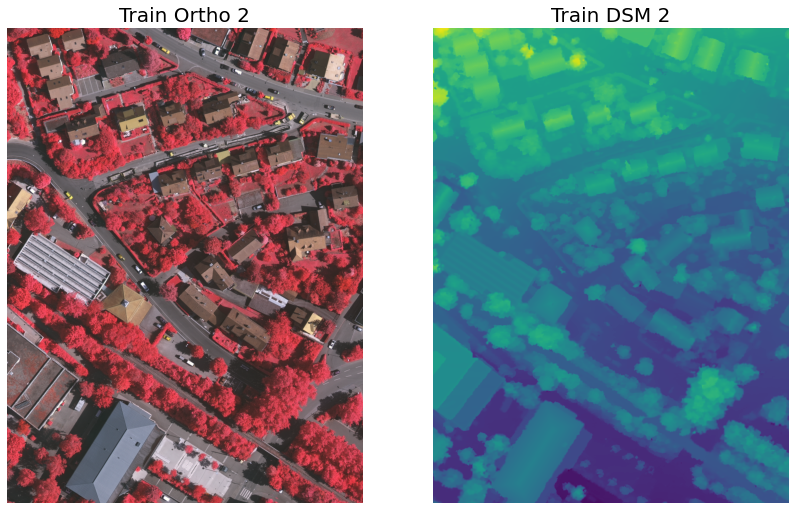

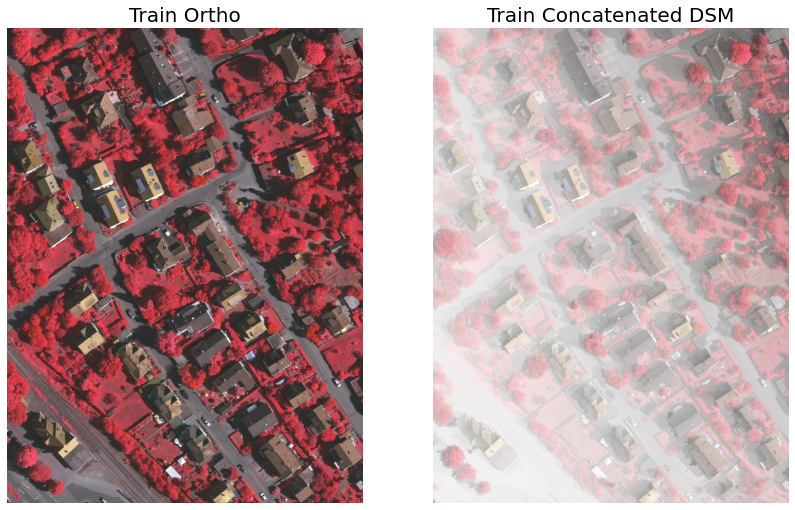

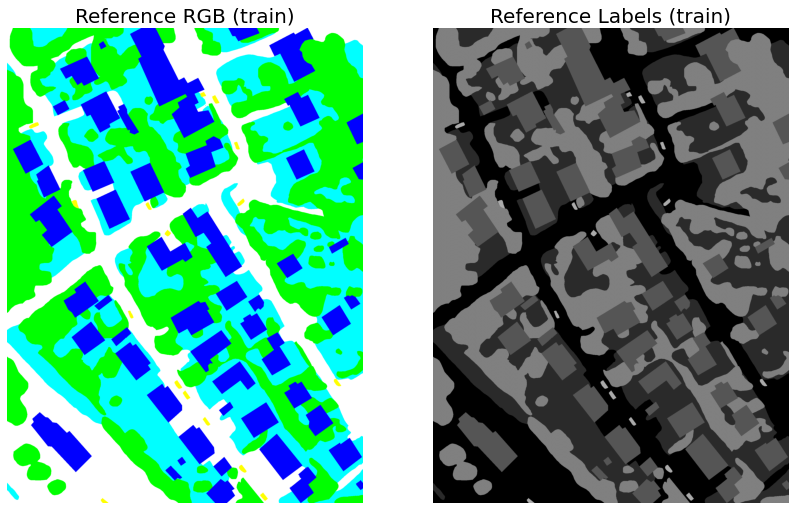

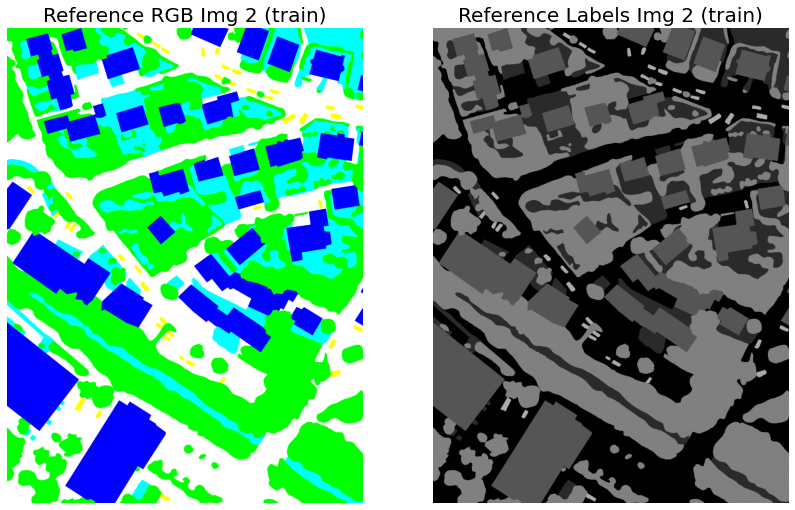

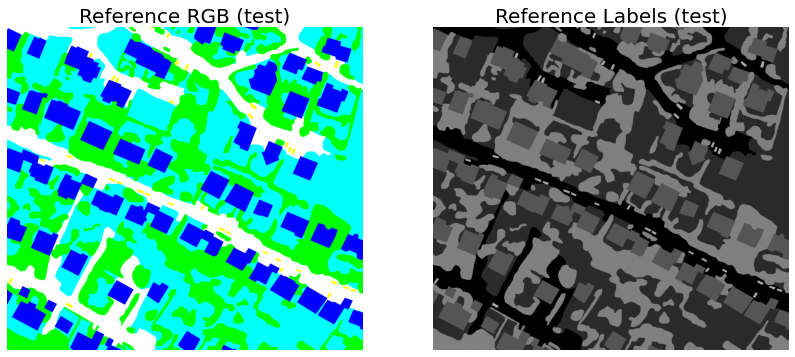

In [ ]:
# Inspecting label images (train and test)

print('\nPlotting images...')

fig0, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(14, 10))
ax1.imshow( image_train )
ax1.set_title('Train Ortho 1', fontsize=20)
ax1.axis('off')
ax2.imshow( image_dsm  )
ax2.set_title('Train DSM 1', fontsize=20)
ax2.axis('off')

fig01, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(14, 10))
ax1.imshow( image_train_2 )
ax1.set_title('Train Ortho 2', fontsize=20)
ax1.axis('off')
ax2.imshow( image_dsm_2 )
ax2.set_title('Train DSM 2', fontsize=20)
ax2.axis('off')

fig012, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(14, 10))
ax1.imshow( image_train )
ax1.set_title('Train Ortho', fontsize=20)
ax1.axis('off')
ax2.imshow( concatenated_train )
ax2.set_title('Train Concatenated DSM', fontsize=20)
ax2.axis('off')

fig1, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(14, 10))
ax1.imshow( reference_train )
ax1.set_title('Reference RGB (train)', fontsize=20)
ax1.axis('off')
ax2.imshow( labels_train, cmap='gray', vmin=0, vmax=num_classes )
ax2.set_title('Reference Labels (train)', fontsize=20)
ax2.axis('off')

fig2, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(14, 10))
ax1.imshow( reference_train_2 )
ax1.set_title('Reference RGB Img 2 (train)', fontsize=20)
ax1.axis('off')
ax2.imshow( labels_train_2, cmap='gray', vmin=0, vmax=num_classes )
ax2.set_title('Reference Labels Img 2 (train)', fontsize=20)
ax2.axis('off')

fig3, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(14, 10))
ax1.imshow( reference_test )
ax1.set_title('Reference RGB (test)', fontsize=20)
ax1.axis('off')
ax2.imshow( labels_test, cmap='gray', vmin=0, vmax=num_classes )
ax2.set_title('Reference Labels (test)', fontsize=20)
ax2.axis('off')

# **5. Extracting image patches for training**

In [ ]:
# Constants and functions

# patch_size defines the measures (spatial dimensions) of the patch.
# Working with square patches (H = W). Therefore, a scalar variable is enough.
patch_size = 256

# patch_stride determine the position of the next patch.
# A patch_stride smaller than the spatial dimension of the patch determines an overlapping.
# 25% ​​overlap between patches.
patch_stride = patch_size - (patch_size // 4)

# channels of the image/patches to be segmented
image_channels = 3

# shape of the input to the network (training)
input_shape = (patch_size, patch_size, image_channels)

# Function: extract_patches
# -------------------------
# Extract patches from the original and reference image
#
# Input parameters:
#   image      = array containing the original image (h,w,c)
#   reference  = array containing the reference image (h,w,c)
#   patch_size = patch size (scalar). The shape of the patch is square.
#   stride     = displacement to be applied.
#   border_patches = include patches overlaping image borders
#
# Returns: 
#   A, B = List containing the patches for the input image (A) and respective reference (B).
#
def extract_patches(image, reference, patch_size, stride, border_patches=False):
    print("Image dimensions:", image.shape)
    print("Reference dimensions:", reference.shape)

    patch_img = []
    patch_ref = []

    h = image.shape[0] // stride
    w = image.shape[1] // stride

    for m in range(0, h):
        for n in range(0, w):
            #print('M %d, N %d, start %d finish %d , start %d finish %d' % (m, n, m*stride , m*stride+patch_size, n*stride, n*stride+patch_size) )
            if ( (m*stride+patch_size <= image.shape[0]) and (n*stride+patch_size <= image.shape[1]) ):
                patch_img.append( image[m*stride:m*stride+patch_size,n*stride:n*stride+patch_size,:] )
                patch_ref.append( reference[m*stride:m*stride+patch_size,n*stride:n*stride+patch_size] )
            elif border_patches:
                border_patch_img = np.zeros((patch_size,patch_size,image_channels))
                border_patch_ref = np.zeros((patch_size,patch_size))
                if (m*stride+patch_size > image.shape[0]):
                  border_mmax = patch_size-(m*stride+patch_size-image.shape[0])
                else:
                  border_mmax = patch_size-1
                if (n*stride+patch_size > image.shape[1]):
                  border_nmax = patch_size-(n*stride+patch_size-image.shape[1])
                else:
                  border_nmax = patch_size-1

                border_patch_img[0:border_mmax,0:border_nmax,:] = image[m*stride:m*stride+border_mmax,n*stride:n*stride+border_nmax,:]
                border_patch_ref[0:border_mmax,0:border_nmax] = reference[m*stride:m*stride+border_mmax,n*stride:n*stride+border_nmax]
                patch_img.append( border_patch_img )
                patch_ref.append( border_patch_ref )
       
    return np.array(patch_img), np.array(patch_ref)


In [ ]:
# Extracting training patches

def generateTrainingPatches(image_train,labels_train):
  #Image 1
  x_patches, y_patches = extract_patches(image_train[0], labels_train[0], patch_size, patch_stride)

  if(len(image_train) > 1):
    #Image 2
    x_patches_2, y_patches_2 = extract_patches(image_train[1], labels_train[1], patch_size, patch_stride)
    x_patches = np.array(concatenate([x_patches,x_patches_2],axis=0))
    y_patches = np.array(concatenate([y_patches,y_patches_2],axis=0))

  #Transform y_patches, shape (N, H, W) into shape (N, H, W, C). Necessary for data agumentation.
  y_patches = np.expand_dims(y_patches, 3)

  print( "Number of patches: %d %s " % ( x_patches.shape[0], x_patches.shape[1:] ) )
  print( "Number of labeled references: %d %s " % ( y_patches.shape[0], y_patches.shape[1:] ) )

  return x_patches, y_patches

Image dimensions: (2565, 1919, 3)
Reference dimensions: (2565, 1919)
Number of patches: 117 (256, 256, 3) 
Number of labeled references: 117 (256, 256, 1) 

Plotting images...


(-0.5, 255.5, 255.5, -0.5)

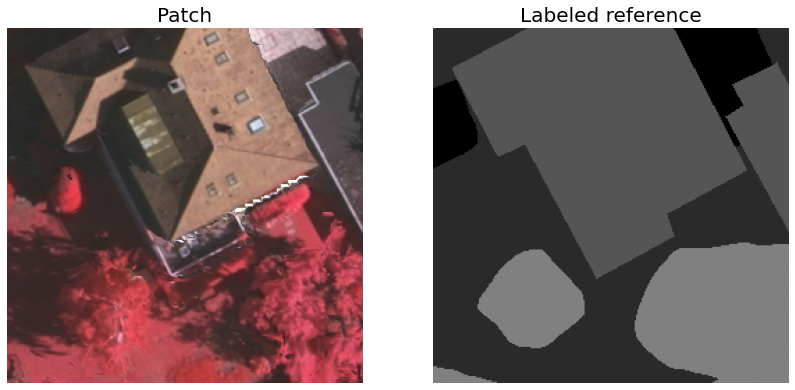

In [ ]:
# Inspecting an arbitrary image patch
x_patches,y_patches = generateTrainingPatches([image_train],[labels_train])

image_index = 20

print('\nPlotting images...')
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(14, 10))

ax1.imshow( x_patches[image_index] )
ax1.set_title('Patch', fontsize=20)
ax1.axis('off')
 
ax2.imshow( y_patches[image_index, :, :, 0], cmap='gray', vmin=0, vmax=num_classes )
ax2.set_title('Labeled reference', fontsize=20)
ax2.axis('off')

# **6. Separating training and validation patches**

In [ ]:
def createTrainingAndValidationDataset(x_patches,y_patches):
  # Defining the percentage of the training set to be used as validation
  valid_percent = 0.2

  # Calculating the boundary (index) between training set and validation.
  # The premise is always that X and Y have the same number of elements.
  limit = len(x_patches) - int( len(x_patches)*valid_percent )

  # Building a list of indexes from 0 to N, where N corresponds to the number of images (patches).
  indexes = [i for i in range(x_patches.shape[0])]

  # Generating randomness in the list
  import random
  random.shuffle(indexes)

  # Indexes of the images that will be used for training
  indexes_for_train = indexes[:limit]
  # ndexes of the images that will be used for validation
  indexes_for_valid = indexes[limit:]

  # Training set
  x_train = x_patches[indexes_for_train]
  y_train = y_patches[indexes_for_train]

  # Validation set
  x_valid = x_patches[indexes_for_valid]
  y_valid = y_patches[indexes_for_valid]

  print( "Número de imagens no conjunto de treinamento: %d " % ( len(x_train) ) )
  print( "Número de imagens no conjunto de validação: %d " % ( len(x_valid) ) )

  # Freeing up memory
  x_patches = 0
  y_patches = 0

  return (x_train,y_train),(x_valid,y_valid)

# **7. Data augmentation**

In [ ]:
# Setting data augmentation tranformations and creating data generators

# Only rotations by 90 degrees
def orthogonal_rot(image):
    return np.rot90(image, np.random.choice([-1, 0, 1]))

# Tranformations for image patches
datagen_args_x = dict(
        #rotation_range=90, # rotation
        # width_shift_range=0.15, # horizontal shift
        # height_shift_range=0.15, # vertical shift
        # zoom_range=0.25, # zoom
        preprocessing_function=orthogonal_rot,
        horizontal_flip=True, # horizontal flip
        vertical_flip=True, # vertical flip
        # brightness_range=[0.8,1.2], # brightness
        fill_mode='constant',
        cval=0
)

# Transformations for reference patches
datagen_args_y = dict(
        #rotation_range=90, # rotation
        # width_shift_range=0.15, # horizontal shift
        # height_shift_range=0.15, # vertical shift
        # zoom_range=0.25, # zoom
        preprocessing_function=orthogonal_rot,
        horizontal_flip=True, # horizontal flip
        vertical_flip=True, # vertical flip
        fill_mode='constant',
        cval=0
)

# Its necessary to provide the same seed and kwargs to the flow method (images and references)
seed = 1
x_datagen = ImageDataGenerator(**datagen_args_x)
y_datagen = ImageDataGenerator(**datagen_args_y)

Image dimensions: (2565, 1919, 3)
Reference dimensions: (2565, 1919)
Number of patches: 117 (256, 256, 3) 
Number of labeled references: 117 (256, 256, 1) 
Número de imagens no conjunto de treinamento: 94 
Número de imagens no conjunto de validação: 23 


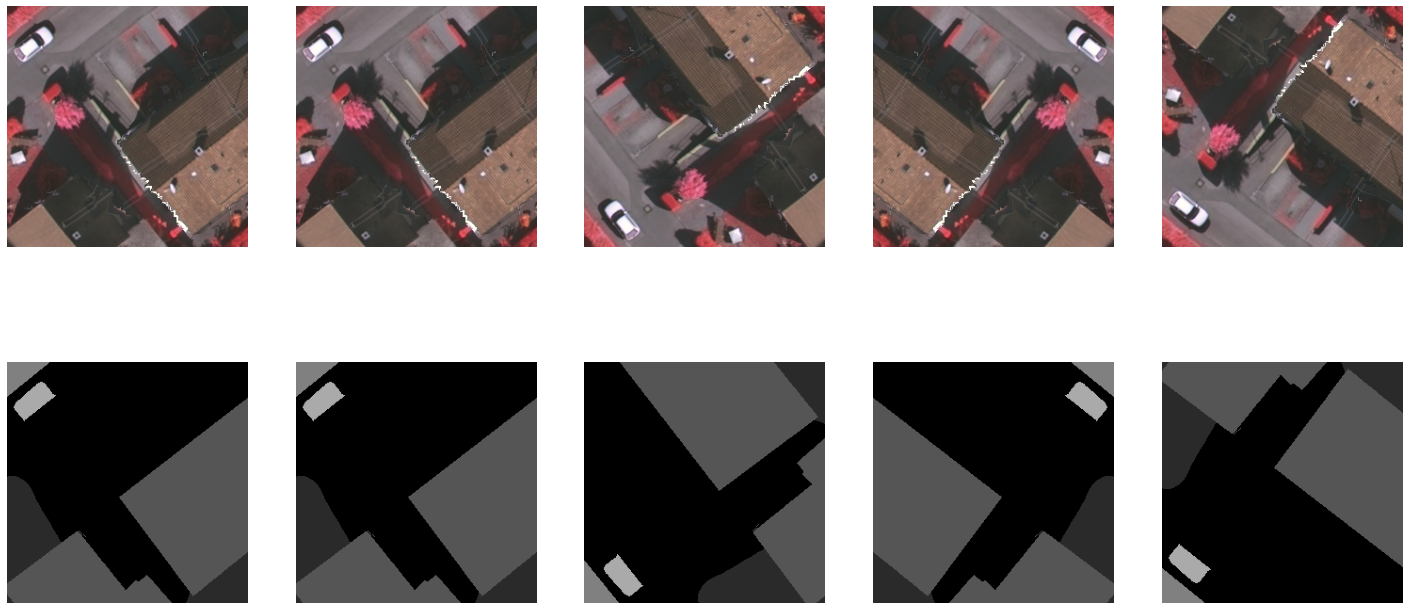

In [ ]:
# Example of Data Augmentation for an arbitrary patch

def showDataAugmentationExample(show_index = 25):
  x_patches,y_patches = generateTrainingPatches([image_train],[labels_train])
  (x_train, y_train), (x_valid, y_valid) = createTrainingAndValidationDataset(x_patches,y_patches)

  x_patch = np.expand_dims( x_train[show_index], 0 )
  y_patch = np.expand_dims( y_train[show_index], 0 )

  x_iterator = x_datagen.flow(x_patch, seed=seed)
  y_iterator = y_datagen.flow(y_patch, seed=seed)

  data_iterator = next( zip( x_iterator, y_iterator ) )

  nrows = 2
  ncols = 5
  fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25,12))

  # generating transformed images
  for j in range(ncols):
      data_iterator = next( zip( x_iterator, y_iterator ) )
      ax[0][j].axis('off')
      ax[0][j].imshow(data_iterator[0][0])
      ax[1][j].axis('off')
      ax[1][j].imshow(data_iterator[1][0,:,:,0], cmap='gray', vmin=0, vmax=num_classes )

showDataAugmentationExample(50)

# **8. Building the CNN model**

In [ ]:
# Defining the structure of the CNN
#Student's note: I tried to implement the exact architecture proposed in the article 
#'U-Net: Convolutional Networks for Biomedical Image Segmentation', 
#however the valid padding from covolutions and the cropping before concatenation didn't work out for me.
#So I changed to keep the same padding at every convolution.

def create_unet(input_shape, n_classes):
    # U-Net architecture
    activation = 'relu'
    kernel=3
    padding_type='same'
    drop = 0.2

    inputs = Input(input_shape)
    conv1 = Conv2D(64, kernel, kernel_initializer='he_normal',padding=padding_type)(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = tf.keras.layers.Activation(activation)(conv1)

    conv1 = Conv2D(64, kernel, kernel_initializer='he_normal',padding=padding_type)(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = tf.keras.layers.Activation(activation)(conv1)    
    #conv1 = Dropout(drop)(conv1)
    pool1 = MaxPooling2D(strides=2)(conv1)

    conv2 = Conv2D(128, kernel, kernel_initializer='he_normal',padding=padding_type)(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = tf.keras.layers.Activation(activation)(conv2)

    conv2 = Conv2D(128, kernel, kernel_initializer='he_normal',padding=padding_type)(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = tf.keras.layers.Activation(activation)(conv2)
    #conv2 = Dropout(drop)(conv2)
    
    pool2 = MaxPooling2D(strides=2)(conv2)

    conv3 = Conv2D(256, kernel, kernel_initializer='he_normal',padding=padding_type)(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = tf.keras.layers.Activation(activation)(conv3)

    conv3 = Conv2D(256, kernel, kernel_initializer='he_normal',padding=padding_type)(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = tf.keras.layers.Activation(activation)(conv3)
    #conv3 = Dropout(drop)(conv3)

    pool3 = MaxPooling2D(strides=2)(conv3)

    conv4 = Conv2D(512, kernel, kernel_initializer='he_normal',padding=padding_type)(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = tf.keras.layers.Activation(activation)(conv4)

    conv4 = Conv2D(512, kernel, kernel_initializer='he_normal',padding=padding_type)(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = tf.keras.layers.Activation(activation)(conv4)
    #conv4 = Dropout(drop)(conv4)
    
    pool4 = MaxPooling2D(strides=2)(conv4)

    conv5 = Conv2D(1024, kernel, kernel_initializer='he_normal',padding=padding_type)(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = tf.keras.layers.Activation(activation)(conv5)

    conv5 = Conv2D(1024, kernel, kernel_initializer='he_normal',padding=padding_type)(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = tf.keras.layers.Activation(activation)(conv5)
    conv5 = Dropout(drop)(conv5)   
    
    
    up6 = Conv2DTranspose(512,kernel_size=2,strides=2,activation = activation,padding=padding_type)(conv5)

    
    merge6 = concatenate([up6,conv4], axis = 3)
    conv6 = Conv2D(512, kernel, activation = activation, kernel_initializer='he_normal',padding=padding_type)(merge6)
    #conv6 = BatchNormalization()(conv6)
    #conv6 = tf.keras.layers.Activation(activation)(conv6)

    conv6 = Conv2D(512, kernel, activation = activation, kernel_initializer='he_normal',padding=padding_type)(conv6)
    #conv6 = BatchNormalization()(conv6)
    #conv6 = tf.keras.layers.Activation(activation)(conv6)

    up7 = Conv2DTranspose(256,kernel_size=2,strides=2,activation = activation,padding=padding_type)(conv6)
    
    merge7 = concatenate([up7,conv3], axis = 3)
    conv7 = Conv2D(256, kernel, activation = activation, kernel_initializer='he_normal',padding=padding_type)(merge7)
    #conv7 = BatchNormalization()(conv7)
    #conv7 = tf.keras.layers.Activation(activation)(conv7)

    conv7 = Conv2D(256, kernel,activation = activation, kernel_initializer='he_normal',padding=padding_type)(conv7)
    #conv7 = BatchNormalization()(conv7)
    #conv7 = tf.keras.layers.Activation(activation)(conv7)

    up8 = Conv2DTranspose(128,kernel_size=2,strides=2,activation = activation,padding=padding_type)(conv7)

    
    merge8 = concatenate([up8,conv2], axis = 3)
    conv8 = Conv2D(128, kernel, activation = activation, kernel_initializer='he_normal',padding=padding_type)(merge8)
    #conv8 = BatchNormalization()(conv8)
    #conv8 = tf.keras.layers.Activation(activation)(conv8)

    conv8 = Conv2D(128, kernel,activation = activation, kernel_initializer='he_normal',padding=padding_type)(conv8)
    #conv8 = BatchNormalization()(conv8)
    #conv8 = tf.keras.layers.Activation(activation)(conv8)
    
    up9 = Conv2DTranspose(64,kernel_size=2,strides=2,activation = activation,padding=padding_type)(conv8)    
    
    merge9 = concatenate([up9,conv1], axis = 3)
    conv9 = Conv2D(64, kernel, activation = activation, kernel_initializer='he_normal',padding=padding_type)(merge9)
    #conv9 = BatchNormalization()(conv9)
    #conv9 = tf.keras.layers.Activation(activation)(conv9)

    conv9 = Conv2D(64, kernel, activation = activation, kernel_initializer='he_normal',padding=padding_type)(conv9)    
    #conv9 = BatchNormalization()(conv9)
    #conv9 = tf.keras.layers.Activation(activation)(conv9)

    conv10 = Conv2D(n_classes, 1, activation = 'softmax')(conv9)    

    unet = Model(inputs=[inputs], outputs=[conv10], name='U-Net')

    return unet

In [ ]:
# Building the model
model = create_unet(input_shape, num_classes)
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

# **9. Functions for training the network**

In [ ]:
# Functions for training

def set_number_of_batches(qt_train_samples, qt_valid_samples, batch_size, 
                          data_augmentation, number_samples_for_generator=6):
    if data_augmentation:
        train_batchs_qtd = qt_train_samples//number_samples_for_generator
        valid_batchs_qtd = qt_valid_samples//number_samples_for_generator
    else:
        train_batchs_qtd = qt_train_samples//batch_size
        valid_batchs_qtd = qt_valid_samples//batch_size

    return train_batchs_qtd, valid_batchs_qtd

def get_batch_samples(x, y, batch, batch_size, data_augmentation, number_samples_for_generator):
    if data_augmentation:
        x_batch = x[batch * number_samples_for_generator : (batch + 1) * number_samples_for_generator, : , : , :]
        y_batch = y[batch * number_samples_for_generator : (batch + 1) * number_samples_for_generator, : , : , :]

        x_iterator = x_datagen.flow(x_batch, seed=batch)
        y_iterator = y_datagen.flow(y_batch, seed=batch)

        x_batch = np.array([next(x_iterator)[0] for _ in range(batch_size)])
        y_batch = np.array([next(y_iterator)[0] for _ in range(batch_size)])
    else:
        x_batch = x[batch * batch_size : (batch + 1) * batch_size, : , : , :]
        y_batch = y[batch * batch_size : (batch + 1) * batch_size, : , : , :]

    return x_batch, y_batch

def train_unet(net, x_train, y_train, x_valid, y_valid, batch_size, epochs, 
               early_stopping_epochs, early_stopping_delta, filepath, filename, 
               data_augmentation=False, number_samples_for_generator=1):
    print('Training started...')

    # calculating number of batches
    train_batchs_qtd, valid_batchs_qtd = set_number_of_batches(x_train.shape[0], 
                                                               x_valid.shape[0], 
                                                               batch_size, 
                                                               data_augmentation, 
                                                               number_samples_for_generator)
         
    history_train = []
    history_valid = []
    valid_loss_best_model = float('inf')
    no_improvement_count = 0

    for epoch in range(epochs):
        print('Epoch %d starting ...' %(epoch) )
        # shuffle train set
        x_train, y_train = shuffle(x_train , y_train, random_state = 0)

        # TRAINING
        train_loss = np.zeros((1 , 2))
        # mini batches strategy
        for  batch in range(train_batchs_qtd):
            #print('Batch %d starting ...' %(batch) )
            x_train_batch, y_train_batch = get_batch_samples(x_train, 
                                                             y_train, 
                                                             batch, 
                                                             batch_size, 
                                                             data_augmentation, 
                                                             number_samples_for_generator)
            train_loss = train_loss + net.train_on_batch(x_train_batch, y_train_batch)
            

        # Estimating the loss in the training set
        train_loss = train_loss/train_batchs_qtd

        # VALIDATING
        valid_loss = np.zeros((1 , 2))        
        # Evaluating the network (model) with the validation set
        for  batch in range(valid_batchs_qtd):
            x_valid_batch, y_valid_batch = get_batch_samples(x_valid, y_valid, batch, 
                                                             batch_size, data_augmentation, 
                                                             number_samples_for_generator)
            valid_loss = valid_loss + net.test_on_batch(x_valid_batch, y_valid_batch)

        # Estimating the loss in the validation set
        valid_loss = valid_loss/valid_batchs_qtd

        # Showing the results.
        print("%d [training loss: %f , Train acc.: %.2f%%][Test loss: %f , Test acc.:%.2f%%]" %(epoch , train_loss[0 , 0], 100*train_loss[0 , 1] , valid_loss[0 , 0] , 100 * valid_loss[0 , 1]))
        history_train.append( train_loss )
        history_valid.append( valid_loss )

        # Early Stopping
        if (1-(valid_loss[0 , 0]/valid_loss_best_model)) < early_stopping_delta:
            if no_improvement_count+1 >= early_stopping_epochs:
                print('Early Stopping reached')
                break
            else:
                no_improvement_count = no_improvement_count+1
        else:
            valid_loss_best_model = valid_loss[0 , 0]
            no_improvement_count = 0

            # Saving best model  
            print("Saving the model...")
            net.save(filepath+filename+'.h5')

    return [ history_train, history_valid ]


# **10. Defining hyperparameters**

In [ ]:
# Defining hyperparameters for training

batch_size = 32
epochs = 200

# Fixed class weights: [Impervious surfaces, Low vegetation, Building, Tree, Car]
class_weights = [0.10, 0.10, 0.10 , 0.10, 2.00]

# Early stoping parameters
early_stopping_epochs = 20
early_stopping_delta = 0.0001 # delta improvement equivalent to 0.01%

data_augmentation = True
number_samples_for_generator = 4

# optimizer
optmzr = Adam(learning_rate = 0.00001 , beta_1=0.9)

# **11. Start training**

#Experiments:

A1: 1 training image

A2: 2 training images

B1: 1 concatenated image (ortho + DSM)

B2: 2 concatenated images (ortho + DSM)

In [ ]:
#Experiment:
#A1: 1 training image

input_shape = (patch_size, patch_size, 3)

x_patches,y_patches = generateTrainingPatches([image_train],[labels_train])
(x_train, y_train), (x_valid, y_valid) = createTrainingAndValidationDataset(x_patches,y_patches)

best_model_filename = 'best_CNN_model_A1'
model_a1 = create_unet(input_shape, num_classes)
model_a1.compile(loss = "sparse_categorical_crossentropy", optimizer=optmzr, metrics=['accuracy'], loss_weights = class_weights)
history_a1 = train_unet(model_a1, x_train, y_train, x_valid, y_valid, batch_size, epochs, early_stopping_epochs, early_stopping_delta, root_path, best_model_filename, data_augmentation, number_samples_for_generator)
#history_a1 = train_unet(model_a1, x_train[0:64], y_train[0:64], x_valid[0:16], y_valid[0:16], batch_size, epochs, early_stopping_epochs, early_stopping_delta, root_path, best_model_filename, data_augmentation, number_samples_for_generator)


Image dimensions: (2565, 1919, 3)
Reference dimensions: (2565, 1919)
Number of patches: 117 (256, 256, 3) 
Number of labeled references: 117 (256, 256, 1) 
Número de imagens no conjunto de treinamento: 94 
Número de imagens no conjunto de validação: 23 
Training started...
Epoch 0 starting ...
0 [training loss: 0.160928 , Train acc.: 35.87%][Test loss: 0.160410 , Test acc.:31.28%]
Saving the model...
Epoch 1 starting ...
1 [training loss: 0.146029 , Train acc.: 45.62%][Test loss: 0.159087 , Test acc.:34.69%]
Saving the model...
Epoch 2 starting ...
2 [training loss: 0.134215 , Train acc.: 50.28%][Test loss: 0.153881 , Test acc.:37.95%]
Saving the model...
Epoch 3 starting ...
3 [training loss: 0.122728 , Train acc.: 51.74%][Test loss: 0.145060 , Test acc.:37.90%]
Saving the model...
Epoch 4 starting ...
4 [training loss: 0.112247 , Train acc.: 54.07%][Test loss: 0.135448 , Test acc.:36.78%]
Saving the model...
Epoch 5 starting ...
5 [training loss: 0.103813 , Train acc.: 57.45%][Test l

In [ ]:
#Experiment:
#A2: 2 training images

input_shape = (patch_size, patch_size, 3)

x_patches,y_patches = generateTrainingPatches([image_train,image_train_2],[labels_train,labels_train_2])
(x_train, y_train), (x_valid, y_valid) = createTrainingAndValidationDataset(x_patches,y_patches)

best_model_filename = 'best_CNN_model_A2'
model_a2 = create_unet(input_shape, num_classes)
model_a2.compile(loss = "sparse_categorical_crossentropy", optimizer=optmzr, metrics=['accuracy'], loss_weights = class_weights)
history_a2 = train_unet(model_a2, x_train, y_train, x_valid, y_valid, batch_size, epochs, early_stopping_epochs, early_stopping_delta, root_path, best_model_filename, data_augmentation, number_samples_for_generator)
#history_a2 = train_unet(model_a2, x_train[0:64], y_train[0:64], x_valid[0:16], y_valid[0:16], batch_size, epochs, early_stopping_epochs, early_stopping_delta, root_path, best_model_filename, data_augmentation, number_samples_for_generator)

Image dimensions: (2565, 1919, 3)
Reference dimensions: (2565, 1919)
Image dimensions: (2546, 1903, 3)
Reference dimensions: (2546, 1903)
Number of patches: 225 (256, 256, 3) 
Number of labeled references: 225 (256, 256, 1) 
Número de imagens no conjunto de treinamento: 180 
Número de imagens no conjunto de validação: 45 
Training started...
Epoch 0 starting ...
0 [training loss: 0.140891 , Train acc.: 44.63%][Test loss: 0.144019 , Test acc.:37.75%]
Saving the model...
Epoch 1 starting ...
1 [training loss: 0.090784 , Train acc.: 62.69%][Test loss: 0.128815 , Test acc.:38.30%]
Saving the model...
Epoch 2 starting ...
2 [training loss: 0.084194 , Train acc.: 65.41%][Test loss: 0.142517 , Test acc.:38.36%]
Epoch 3 starting ...
3 [training loss: 0.079646 , Train acc.: 67.39%][Test loss: 0.133809 , Test acc.:39.88%]
Epoch 4 starting ...
4 [training loss: 0.078582 , Train acc.: 68.61%][Test loss: 0.147824 , Test acc.:39.40%]
Epoch 5 starting ...
5 [training loss: 0.072112 , Train acc.: 71.4

In [ ]:
#Experiment:
#B1: 1 concatenated image (Ortho + DSM)

input_shape = (patch_size, patch_size, 4)

x_patches,y_patches = generateTrainingPatches([concatenated_train],[labels_train])
(x_train, y_train), (x_valid, y_valid) = createTrainingAndValidationDataset(x_patches,y_patches)


best_model_filename = 'best_CNN_model_B1'
model_b1 = create_unet(input_shape, num_classes)
model_b1.compile(loss = "sparse_categorical_crossentropy", optimizer=optmzr, metrics=['accuracy'], loss_weights = class_weights)
history_b1 = train_unet(model_b1, x_train, y_train, x_valid, y_valid, batch_size, epochs, early_stopping_epochs, early_stopping_delta, root_path, best_model_filename, data_augmentation, number_samples_for_generator)
#history_b1 = train_unet(model_b1, x_train[0:64], y_train[0:64], x_valid[0:16], y_valid[0:16], batch_size, epochs, early_stopping_epochs, early_stopping_delta, root_path, best_model_filename, data_augmentation, number_samples_for_generator)

Image dimensions: (2565, 1919, 4)
Reference dimensions: (2565, 1919)
Number of patches: 117 (256, 256, 4) 
Number of labeled references: 117 (256, 256, 1) 
Número de imagens no conjunto de treinamento: 94 
Número de imagens no conjunto de validação: 23 
Training started...
Epoch 0 starting ...
0 [training loss: 0.191011 , Train acc.: 20.90%][Test loss: 0.186270 , Test acc.:3.13%]
Saving the model...
Epoch 1 starting ...
1 [training loss: 0.169934 , Train acc.: 27.40%][Test loss: 0.175126 , Test acc.:29.08%]
Saving the model...
Epoch 2 starting ...
2 [training loss: 0.154508 , Train acc.: 35.75%][Test loss: 0.167475 , Test acc.:36.90%]
Saving the model...
Epoch 3 starting ...
3 [training loss: 0.138012 , Train acc.: 46.48%][Test loss: 0.156723 , Test acc.:40.08%]
Saving the model...
Epoch 4 starting ...
4 [training loss: 0.119605 , Train acc.: 54.77%][Test loss: 0.142264 , Test acc.:48.69%]
Saving the model...
Epoch 5 starting ...
5 [training loss: 0.103370 , Train acc.: 60.38%][Test lo

In [ ]:
#Experiment:
#B2: 2 concatenated images (Ortho + DSM)

x_patches,y_patches = generateTrainingPatches([concatenated_train,concatenated_train_2],[labels_train,labels_train_2])
(x_train, y_train), (x_valid, y_valid) = createTrainingAndValidationDataset(x_patches,y_patches)

input_shape = (patch_size, patch_size, 4)

best_model_filename = 'best_CNN_model_B2'
model_b2 = create_unet(input_shape, num_classes)
model_b2.compile(loss = "sparse_categorical_crossentropy", optimizer=optmzr, metrics=['accuracy'], loss_weights = class_weights)
history_b2 = train_unet(model_b2, x_train, y_train, x_valid, y_valid, batch_size, epochs, early_stopping_epochs, early_stopping_delta, root_path, best_model_filename, data_augmentation, number_samples_for_generator)
#history_b2 = train_unet(model_b2, x_train[0:64], y_train[0:64], x_valid[0:16], y_valid[0:16], batch_size, epochs, early_stopping_epochs, early_stopping_delta, root_path, best_model_filename, data_augmentation, number_samples_for_generator)

Image dimensions: (2565, 1919, 4)
Reference dimensions: (2565, 1919)
Image dimensions: (2546, 1903, 4)
Reference dimensions: (2546, 1903)
Number of patches: 225 (256, 256, 4) 
Number of labeled references: 225 (256, 256, 1) 
Número de imagens no conjunto de treinamento: 180 
Número de imagens no conjunto de validação: 45 
Training started...
Epoch 0 starting ...
0 [training loss: 0.137425 , Train acc.: 45.35%][Test loss: 0.150408 , Test acc.:44.67%]
Saving the model...
Epoch 1 starting ...
1 [training loss: 0.088357 , Train acc.: 64.36%][Test loss: 0.148377 , Test acc.:37.24%]
Saving the model...
Epoch 2 starting ...
2 [training loss: 0.080286 , Train acc.: 67.89%][Test loss: 0.143389 , Test acc.:39.24%]
Saving the model...
Epoch 3 starting ...
3 [training loss: 0.076848 , Train acc.: 69.52%][Test loss: 0.175929 , Test acc.:35.37%]
Epoch 4 starting ...
4 [training loss: 0.074832 , Train acc.: 69.65%][Test loss: 0.100852 , Test acc.:57.74%]
Saving the model...
Epoch 5 starting ...
5 [tr

# **12. Training History Graph**

In [ ]:
# Functions

def show_graph_loss_accuracy(history,accuracy_position):
    plt.rcParams['axes.facecolor']='white'
    plt.figure(num=1, figsize=(14,6))

    config = [ { 'title': 'model accuracy', 'ylabel': 'accuracy', 'legend_position': 'upper left', 'index_position': accuracy_position },
               { 'title': 'model loss', 'ylabel': 'loss', 'legend_position': 'upper right', 'index_position': 0 } ]

    for i in range(len(config)):
        
        plot_number = 120 + (i+1)
        plt.subplot(plot_number)
        plt.plot(history[0,:,0,config[i]['index_position']])
        plt.plot(history[1,:,0,config[i]['index_position']])
        plt.title(config[i]['title'])
        plt.ylabel(config[i]['ylabel'])
        #plt.axis(ylim=(0, 1))
        plt.xlabel('epoch')
        plt.legend(['train', 'valid'], loc=config[i]['legend_position'])
        plt.tight_layout()

    plt.show()

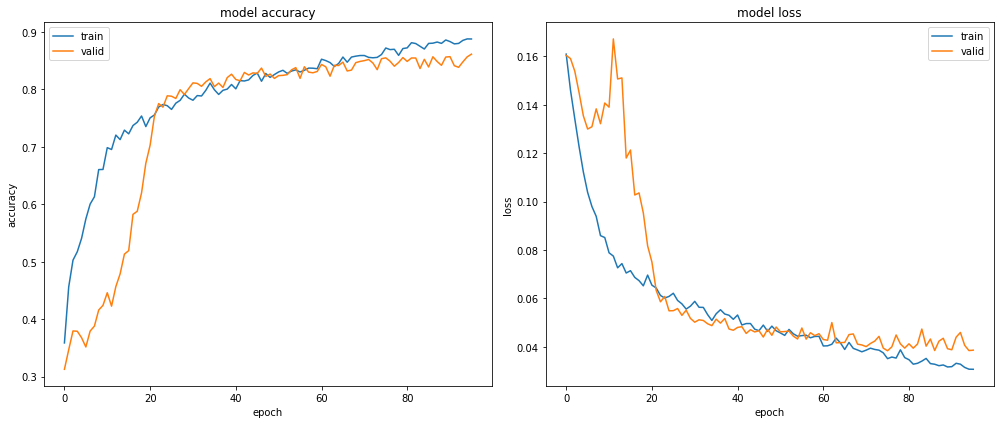

In [ ]:
# Show history
# Experiment A1
#import numpy as np
#from keras.models import load_model
#model_a1 = load_model(root_path + '/best_CNN_model_A1.h5')
show_graph_loss_accuracy(np.asarray(history_a1),1)

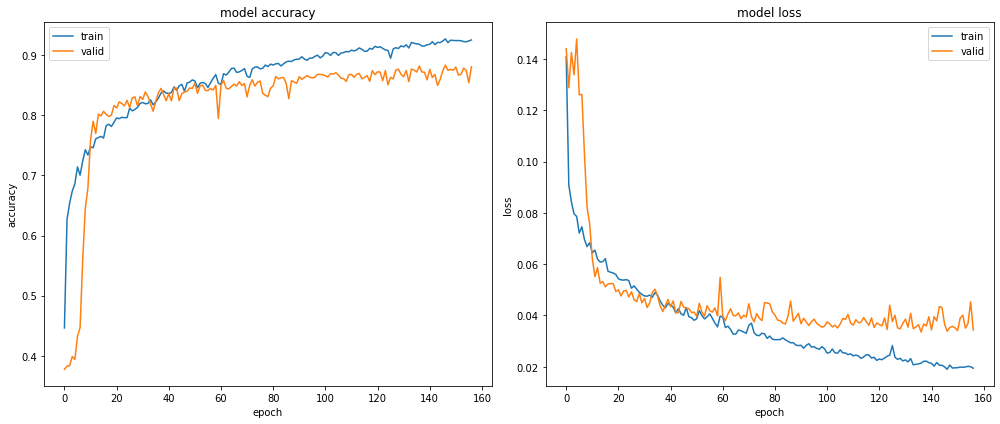

In [ ]:
# Show history
# Experiment A2
import numpy as np
show_graph_loss_accuracy(np.asarray(history_a2),1)

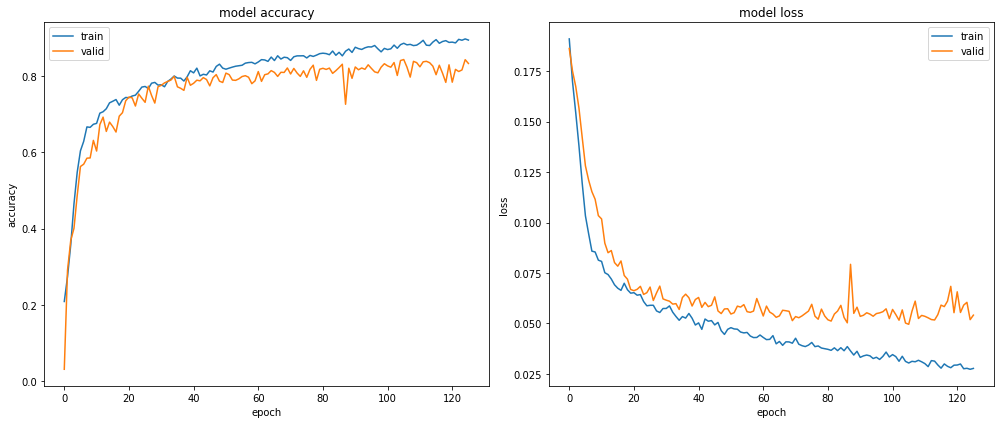

In [ ]:
# Show history
# Experiment B1
import numpy as np
show_graph_loss_accuracy(np.asarray(history_b1),1)

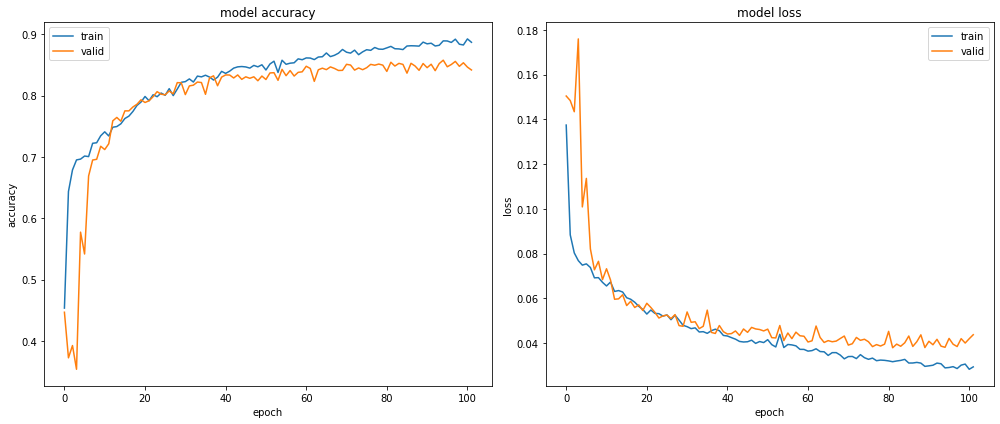

In [ ]:
# Show history
# Experiment B2
import numpy as np
show_graph_loss_accuracy(np.asarray(history_b2),1)

# **13. Evaluating the CNN model over training and validation data**

In [ ]:
# Functions

def Test(model, patch_test):
    result = model.predict(patch_test)
    predicted_classes = np.argmax(result, axis=-1)
    return predicted_classes

def compute_metrics(true_labels, predicted_labels):
    accuracy = 100*accuracy_score(true_labels, predicted_labels)
    f1score = 100*f1_score(true_labels, predicted_labels, average=None)
    recall = 100*recall_score(true_labels, predicted_labels, average=None)
    precision = 100*precision_score(true_labels, predicted_labels, average=None)
    return accuracy, f1score, recall, precision

In [ ]:
# load the best model (.h5 file)
#model_a1 = load_model(root_path + 'best_CNN_model_A1.h5', compile=False)

# Test the model over training and validation data
pred_train_a1 = Test(model_a1, x_train)
pred_valid_a1 = Test(model_a1, x_valid)

In [ ]:
#model_a2 = load_model(root_path + 'best_CNN_model_A2.h5', compile=False)
pred_train_a2 = Test(model_a2, x_train)
pred_valid_a2 = Test(model_a2, x_valid)

In [ ]:
#model_b1 = load_model(root_path + 'best_CNN_model_B1.h5', compile=False)
pred_train_b1 = Test(model_b1, x_train)
pred_valid_b1 = Test(model_b1, x_valid)

In [ ]:
#model_b2 = load_model(root_path + 'best_CNN_model_B2.h5', compile=False)
pred_train_b2 = Test(model_b2, x_train)
pred_valid_b2 = Test(model_b2, x_valid)

In [ ]:
# Showing the prediction for an arbitrary training patch
def showPredition(x_train,y_train,pred_train,index = 20):
  index = 20

  print('\nPlotting images...')
  fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15, 15))

  ax1.imshow(x_train[index])
  ax1.set_title('Patch', fontsize=20)
  ax1.axis('off')

  ax2.imshow( y_train[index, :, :, 0], cmap='gray', vmin=0, vmax=num_classes )
  ax2.set_title('Reference', fontsize=20)
  ax2.axis('off')

  ax3.imshow( pred_train[index], cmap='gray', vmin=0, vmax=num_classes )
  ax3.set_title('Prediction', fontsize=20)
  ax3.axis('off')

#showPredition(x_train,y_train,pred_train_a1,index = 20)

In [ ]:
def formatTruePredLabels(y,pred):
  true_labels = np.reshape(y, (y.shape[0]* y.shape[1]*y.shape[2]))
  predicted_labels = np.reshape(pred, (pred.shape[0]* pred.shape[1]*pred.shape[2]))
  return true_labels,predicted_labels

def showConfusionMatrix(true_labels, predicted_labels):
  # Confusion Matrix
  cm = confusion_matrix(true_labels, predicted_labels)
  print('Confusion  matrix')
  print('=================')
  print(cm)

def showMetrics(true_labels, predicted_labels):
  # Metrics
  metrics = compute_metrics(true_labels, predicted_labels)
  print('\nMetrics')
  print('=======')
  print('Accuracy: ', metrics[0])
  print('F1score: ', metrics[1])
  print('Recall: ', metrics[2])
  print('Precision: ', metrics[3])

In [ ]:
# Showing the confusion matrix and accuracy metrics for the training data
#Experiment A1:
true_labels,predicted_labels = formatTruePredLabels(y_train,pred_train_a1)
showConfusionMatrix(true_labels, predicted_labels)
showMetrics(true_labels, predicted_labels)

Confusion  matrix
[[1088748  107149   76001   60020     103       6]
 [  92679 1014094  133859  342760     121       1]
 [  59073   83366 1029461   14275      97       2]
 [  38705  295490   24935 1685539     112       5]
 [   7955    3004    2647     162      15       0]
 [      0       0       0       0       0       0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Metrics
Accuracy:  78.20708903860537
F1score:  [83.136332   65.70909186 83.92879927 81.27893581  0.21080739  0.        ]
Recall:  [81.73618102 64.04073472 86.78104721 82.43107103  0.10882972  0.        ]
Precision:  [84.58528854 67.46670055 81.2580758  80.15856333  3.34821429  0.        ]


In [ ]:
# Showing the confusion matrix and accuracy metrics for the validation data
#Experiment A1:
true_labels,predicted_labels = formatTruePredLabels(y_valid,pred_valid_a1)
showConfusionMatrix(true_labels, predicted_labels)
showMetrics(true_labels, predicted_labels)

Confusion  matrix
[[391571  33343  21777  17287     24      0]
 [ 31501 215120  37706  66671     31      1]
 [ 12202  14974 269082   1739     33      0]
 [ 12100  62792   4606 308865     29      1]
 [  3854    746   1068    204      1      0]
 [     0      0      0      0      0      0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Metrics
Accuracy:  78.59198528787364
F1score:  [8.55677808e+01 6.34567592e+01 8.51163033e+01 7.88767032e+01
 3.33834084e-02 0.00000000e+00]
Recall:  [8.43899380e+01 6.12825115e+01 9.02868839e+01 7.95238328e+01
 1.70270730e-02 0.00000000e+00]
Precision:  [86.77896762 65.79096261 80.50586556 78.24002067  0.84745763  0.        ]


In [ ]:
evaluation_a1 = model_a1.evaluate(x_valid,  y_valid, verbose=2)
print('Loss: ', evaluation_a1[0])
print('Accuracy: ', evaluation_a1[1])

1/1 - 1s - loss: 0.0593 - accuracy: 0.7859 - 680ms/epoch - 680ms/step
Loss:  0.05932657793164253
Accuracy:  0.7859198451042175


In [ ]:
# Showing the confusion matrix and accuracy metrics for the training data
#Experiment A2:
true_labels,predicted_labels = formatTruePredLabels(y_train,pred_train_a2)
showConfusionMatrix(true_labels, predicted_labels)
showMetrics(true_labels, predicted_labels)

Confusion  matrix
[[2544969  107861  198238  148133     863]
 [ 171746 1438530  116800  600035     879]
 [  47123   71184 1959656   25071     724]
 [ 169561  220654   24079 3891745     240]
 [  47808    1051    4437    1737    3356]]

Metrics
Accuracy:  83.39992947048611
F1score:  [85.0979332  69.03944309 88.93443293 86.74345258 10.41411305]
Recall:  [84.83049028 61.79279121 93.15025778 90.37373101  5.74765795]
Precision:  [85.36706777 78.21158279 85.08368755 83.39356477 55.36126691]


In [ ]:
# Showing the confusion matrix and accuracy metrics for the validation data
#Experiment A2:
true_labels,predicted_labels = formatTruePredLabels(y_valid,pred_valid_a2)
showConfusionMatrix(true_labels, predicted_labels)
showMetrics(true_labels, predicted_labels)

Confusion  matrix
[[610360  32803  64445  20737    304]
 [ 36566 305330  37340 168037    228]
 [ 12961  24235 824608   9645    427]
 [ 25913  55413   6321 698495    176]
 [ 13133    210    821    126    486]]

Metrics
Accuracy:  82.71209716796875
F1score:  [85.50962397 63.24858207 91.34850735 82.98828888  5.92791364]
Recall:  [83.76598335 55.76793467 94.57858686 88.83110904  3.28911749]
Precision:  [87.32739762 73.04702733 88.33177117 77.86665032 29.98149291]


In [ ]:
evaluation_a2 = model_a2.evaluate(x_valid,  y_valid, verbose=2)
print('Loss: ', evaluation_a2[0])
print('Accuracy: ', evaluation_a2[1])

2/2 - 1s - loss: 0.0527 - accuracy: 0.8271 - 862ms/epoch - 431ms/step
Loss:  0.0527019239962101
Accuracy:  0.8271209597587585


In [ ]:
# Showing the confusion matrix and accuracy metrics for the training data
#Experiment B1:
true_labels,predicted_labels = formatTruePredLabels(y_train,pred_train_b1)
showConfusionMatrix(true_labels, predicted_labels)
showMetrics(true_labels, predicted_labels)

Confusion  matrix
[[1357306   41436   29375   29348    1110]
 [ 113487 1226093   58492  134473     723]
 [  17703   16816 1229493    7316    1278]
 [  40113  108262   35129 1693877      59]
 [  13644     119     948      88    3696]]

Metrics
Accuracy:  89.45002454392453
F1score:  [90.46209913 83.80693877 93.63845146 90.52013311 29.14711565]
Recall:  [93.05699056 79.9659942  96.61222719 90.22269686 19.9837794 ]
Precision:  [88.00799869 88.03547862 90.84227785 90.81953695 53.83046898]


In [ ]:
# Showing the confusion matrix and accuracy metrics for the validation data
#Experiment B1:
true_labels,predicted_labels = formatTruePredLabels(y_valid,pred_valid_b1)
showConfusionMatrix(true_labels, predicted_labels)
showMetrics(true_labels, predicted_labels)

Confusion  matrix
[[317257   4141   4316  11556    184]
 [ 25343 268531  17798  89529     75]
 [  7839   4509 195720   2804    826]
 [ 13166  43541   6463 492558     11]
 [  1120      1      0      0     40]]

Metrics
Accuracy:  84.52745520550272
F1score:  [90.36356826 74.38542159 89.78084611 85.49973702  3.48280366]
Recall:  [94.01488796 66.9192775  92.45245586 88.63117399  3.44530577]
Precision:  [86.98526287 83.72676734 87.25930351 82.58202321  3.52112676]


In [ ]:
evaluation_b1 = model_b1.evaluate(x_valid,  y_valid, verbose=2)
print('Loss: ', evaluation_b1[0])
print('Accuracy: ', evaluation_b1[1])

1/1 - 1s - loss: 0.0450 - accuracy: 0.8453 - 674ms/epoch - 674ms/step
Loss:  0.04495671018958092
Accuracy:  0.8452745676040649


In [ ]:
# Showing the confusion matrix and accuracy metrics for the training data
#Experiment B2:
true_labels,predicted_labels = formatTruePredLabels(y_train,pred_train_b2)
showConfusionMatrix(true_labels, predicted_labels)
showMetrics(true_labels, predicted_labels)

Confusion  matrix
[[2581728  175020  126417  209115    6282]
 [  95485 1614844  124682  410414    1140]
 [  50099   40048 2188680   33616     538]
 [  69291  358044   43486 3603747      78]
 [  41129    6581    4141    1414   10461]]

Metrics
Accuracy:  84.76647271050346
F1score:  [86.98113672 72.72267108 91.187648   86.49388596 25.44481605]
Recall:  [83.32019821 71.88058213 94.62593943 88.44319237 16.41559175]
Precision:  [90.97857021 73.58472425 87.99046075 84.6286528  56.54900265]


In [ ]:
# Showing the confusion matrix and accuracy metrics for the validation data
#Experiment B2:
true_labels,predicted_labels = formatTruePredLabels(y_valid,pred_valid_b2)
showConfusionMatrix(true_labels, predicted_labels)
showMetrics(true_labels, predicted_labels)

Confusion  matrix
[[458935  56149  64637  47885   2545]
 [ 32705 440241  42145 113267    568]
 [ 14837  14471 621619  11413    313]
 [ 11724 132052  12169 861991     15]
 [  5451    596   1876    180   1336]]

Metrics
Accuracy:  80.84181043836806
F1score:  [79.55170857 69.19661908 88.48045583 83.98659903 18.79572313]
Recall:  [72.82936947 69.99885519 93.80761877 84.67902679 14.15404174]
Precision:  [87.64121974 68.41256299 83.72581979 83.3054035  27.96734352]


In [ ]:
evaluation_b2 = model_b2.evaluate(x_valid,  y_valid, verbose=2)
print('Loss: ', evaluation_b2[0])
print('Accuracy: ', evaluation_b2[1])

2/2 - 1s - loss: 0.0551 - accuracy: 0.8084 - 862ms/epoch - 431ms/step
Loss:  0.05513644590973854
Accuracy:  0.8084180951118469


In [ ]:
# Freeing up memory

x_train = 0
y_train = 0
x_valid = 0
y_valid = 0
pred_train = 0
pred_valid = 0
true_labels = 0
predicted_labels = 0

# **14. Inference (testing the CNN model)**

In [ ]:
# load the best model (.h5 file)
best_model_filename = 'best_CNN_model_A2'
model = load_model(root_path + best_model_filename + '.h5', compile=False)

In [ ]:
# Constants

# patch_size defines the measures (spatial dimensions) of the patch.
# Working with square patches (H = W). Therefore, a scalar variable is enough.
patch_test_size = patch_size
patch_test_stride = 128


In [ ]:
# Extracting test patches

x_patches_test, y_patches_test = extract_patches(image_test, labels_test, patch_test_size, patch_test_stride, True)

print( "Number of patches: %d %s " % ( x_patches_test.shape[0], x_patches_test.shape[1:] ) )
print( "Number of labeled references: %d %s " % ( y_patches_test.shape[0], y_patches_test.shape[1:] ) )

Image dimensions: (2558, 2818, 3)
Reference dimensions: (2558, 2818)
Number of patches: 418 (256, 256, 3) 
Number of labeled references: 418 (256, 256) 


# **15. Prediction over test patches**

In [ ]:
# Test the model over test patches 

pred_test_patches = Test(model, x_patches_test)
print(pred_test_patches.shape)

(418, 256, 256)



Plotting images...


(-0.5, 255.5, 255.5, -0.5)

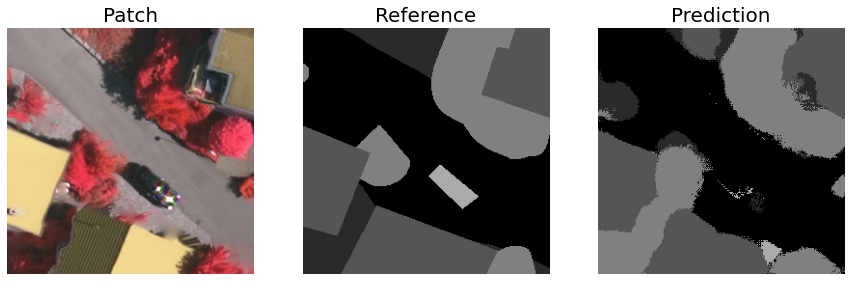

In [ ]:
# Showing prediction result for an arbitrary test patch

index = 40

print('\nPlotting images...')
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15, 15))

ax1.imshow(x_patches_test[index])
ax1.set_title('Patch', fontsize=20)
ax1.axis('off')

ax2.imshow( y_patches_test[index], cmap='gray', vmin=0, vmax=num_classes )
ax2.set_title('Reference', fontsize=20)
ax2.axis('off')

ax3.imshow( pred_test_patches[index], cmap='gray', vmin=0, vmax=num_classes )
ax3.set_title('Prediction', fontsize=20)
ax3.axis('off')


In [ ]:
# Showing the confusion matrix and accuracy metrics for the test data (patches)

true_labels = np.reshape(y_patches_test, (y_patches_test.shape[0]* y_patches_test.shape[1]*y_patches_test.shape[2]))
predicted_labels = np.reshape(pred_test_patches, (pred_test_patches.shape[0]* pred_test_patches.shape[1]*pred_test_patches.shape[2]))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
print('Confusion  matrix')
print('=================')
print(cm)

# Metrics
metrics = compute_metrics(true_labels, predicted_labels)
print('\nMetrics')
print('=======')
print('Accuracy: ', metrics[0])
print('F1score: ', metrics[1])
print('Recall: ', metrics[2])
print('Precision: ', metrics[3])

Confusion  matrix
[[3591367  280153  228026  881703   15519]
 [ 503339 5042939 1011630 2908588    4172]
 [ 204195  198184 4394698   70319    4905]
 [ 103863  721988   93820 7029808      24]
 [  60910    8725    2072    2960   30141]]

Metrics
Accuracy:  73.33327663001832
F1score:  [75.92387332 64.14868683 82.89891099 74.61500181 37.77801453]
Recall:  [71.87379922 53.24797575 90.19758837 88.43078618 28.75830089]
Precision:  [80.45764543 80.66135433 76.6930076  64.53285657 55.04099633]


# **16. Mosaic of the test patches predictions**

In [ ]:
# Assembling mosaic of the test patches predictions

pred_test_mosaic = np.zeros(labels_test.shape)
patch_test_overlap = patch_test_stride/patch_test_size

# Image positions
x = y = 0
xmax, ymax = labels_test.shape 

# Patch positions
pi = patch_test_size//2 - int(patch_test_size*patch_test_overlap**2)
pf = patch_test_size//2 + int(patch_test_size*patch_test_overlap**2)
 
for patch in pred_test_patches:
  if y==0: ypi = 0 
  else: ypi = pi
  if y+pf+patch_test_stride>ymax: ypf = ymax-y-2
  else: ypf = pf
  if x==0: xpi = 0 
  else: xpi = pi
  if x+pf+patch_test_stride>xmax: xpf = xmax-x 
  else: xpf = pf

  pred_test_mosaic[x+xpi:x+xpf,y+ypi:y+ypf] = patch[xpi:xpf,ypi:ypf]

  y += patch_test_stride
  if y+patch_test_stride >= ymax:
    x += patch_test_stride
    y = 0



Plotting images...


(-0.5, 2817.5, 2557.5, -0.5)

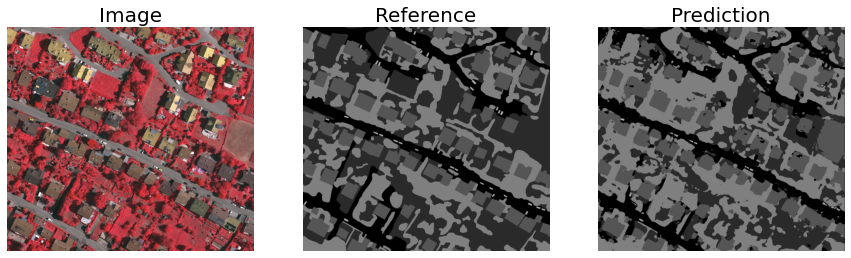

In [ ]:
# Showing prediction results mosaic

print('\nPlotting images...')
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15, 15))

ax1.imshow( image_test )
ax1.set_title('Image', fontsize=20)
ax1.axis('off')

ax2.imshow( labels_test, cmap='gray', vmin=0, vmax=num_classes )
ax2.set_title('Reference', fontsize=20)
ax2.axis('off')

ax3.imshow( pred_test_mosaic, cmap='gray', vmin=0, vmax=num_classes )
ax3.set_title('Prediction', fontsize=20)
ax3.axis('off')


In [ ]:
# Showing the confusion matrix and accuracy metrics for the prediction results mosaic

true_labels = np.reshape(labels_test, (labels_test.shape[0]*labels_test.shape[1]))
predicted_labels = np.reshape(pred_test_mosaic, (pred_test_mosaic.shape[0]*pred_test_mosaic.shape[1]))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
print('Confusion  matrix')
print('=================')
print(cm)

# Metrics
metrics = compute_metrics(true_labels, predicted_labels)
print('\nMetrics')
print('=======')
print('Accuracy: ', metrics[0])
print('F1score: ', metrics[1])
print('Recall: ', metrics[2])
print('Precision: ', metrics[3])

Confusion  matrix
[[ 990804   63959   51211   73875    5375]
 [ 132838 1342929  268030  803493    1814]
 [  69887   47049 1161920   22157    1755]
 [  27241  184207   24073 1908775      10]
 [  14963    1783     151     784    9361]]

Metrics
Accuracy:  75.1034342501655
F1score:  [81.85225925 64.1164508  82.75332576 77.06944133 41.2769804 ]
Recall:  [83.59634972 52.6823935  89.18855852 89.01598    34.61652245]
Precision:  [80.17945624 81.88955972 77.1842419  67.95008622 51.11111111]
